In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Part 2: Fit a Neural Radiance Field from Multi-view Images

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import imageio
# from tqdm import tqdm
from tqdm.notebook import tqdm
import math

- images_train : This will be a NumPy array containing 100 training images, each of size $200 \times 200$ pixels and 3 color channels (RGB). After loading, we normalize by dividing by 255.0 to get pixel values in the range [0,1].
- c2ws_train : A NumPy array of shape [100, 4, 4], containing 100 camera-to-world transformation matrices for the training images.
- images_val : Similar to images_train but for validation images. 10 images total.
- c2ws_val : 10 camera-to-world transformations corresponding to the validation images.
- c2ws_test : 60 camera-to-world transforms for test (novel) views. There are no ground-truth images for these; you'll use them for novel view synthesis after training.
- focal : A single float representing the camera's focal length.

to summarize
- images_train: $(100,200,200,3)$
- c2ws_train: $(100,4,4)$
- images_val: $(10,200,200,3)$
- c2ws_val: $(10,4,4)$
- c2ws_test: $(60,4,4)$
- focal : A single float ( $277.7777 .$. )

In [3]:
data = np.load(f"lego_200x200.npz")
images_train = data["images_train"] / 255.0
c2ws_train = data["c2ws_train"]
images_val = data["images_val"] / 255.0
c2ws_val = data["c2ws_val"]
c2ws_test = data["c2ws_test"]
focal = data["focal"]

print(list(data.keys()))
print(images_train.shape)
print(c2ws_train.shape)
print(images_val.shape)
print(c2ws_val.shape)
print(c2ws_test.shape)
print(focal)

['images_train', 'images_val', 'c2ws_train', 'c2ws_val', 'c2ws_test', 'focal']
(100, 200, 200, 3)
(100, 4, 4)
(10, 200, 200, 3)
(10, 4, 4)
(60, 4, 4)
277.77775779844205


3D scatter plot of all camera centers for training, validation, and test sets:
- Training camera centers are plotted in black.
- Validation camera centers are plotted in red.
- Test camera centers are plotted in green.

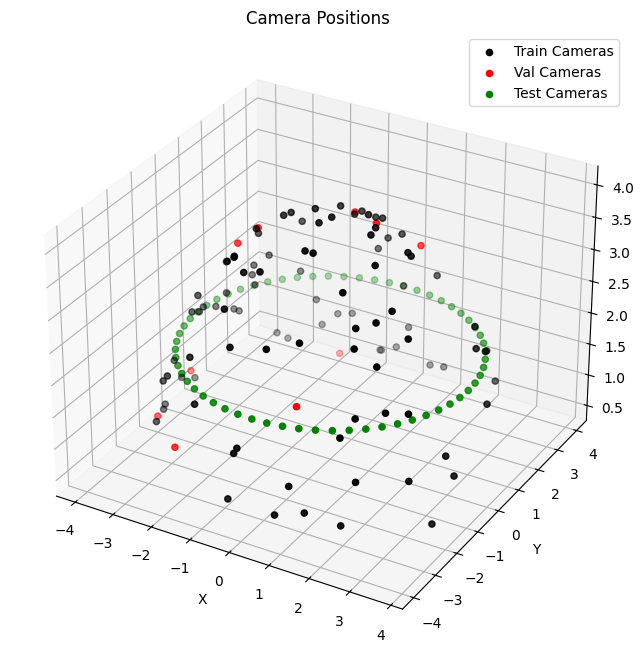

In [4]:
cam_centers_train = c2ws_train[:, :3, 3]
cam_centers_val = c2ws_val[:, :3, 3]
cam_centers_test = c2ws_test[:, :3, 3]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(cam_centers_train[:,0], cam_centers_train[:,1], cam_centers_train[:,2], c='k', label='Train Cameras')
ax.scatter(cam_centers_val[:,0], cam_centers_val[:,1], cam_centers_val[:,2], c='r', label='Val Cameras')
ax.scatter(cam_centers_test[:,0], cam_centers_test[:,1], cam_centers_test[:,2], c='g', label='Test Cameras')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
ax.set_title("Camera Positions")
plt.show()

Visual of the first 16 training images in a $4 \times 4$ grid.
This is at best the quality we should be able to get.

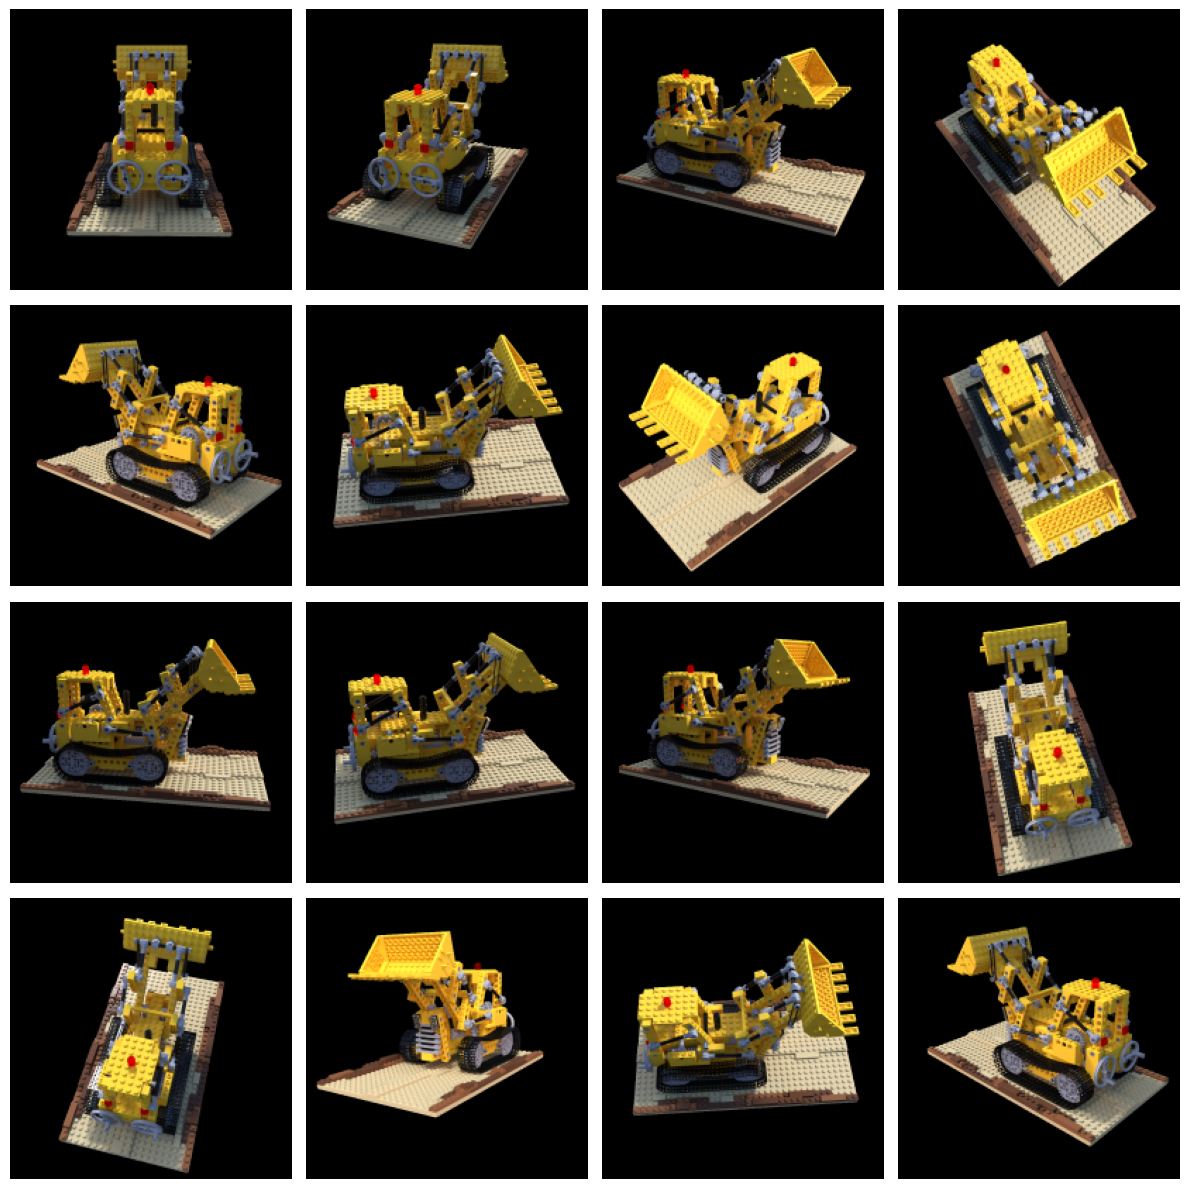

In [5]:
num_images = 16
grid_size = 4
fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
for i in range(num_images):
    row = i // grid_size
    col = i % grid_size
    axes[row, col].imshow(images_train[i])
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

### Part 2.1: Create Rays from Cameras

[Impl] In this session you would need to implement a function $x_{-} w=$ transform $\left(c 2 w, x_{-} c\right)$ that transform a point from camera to the world space. You can verify your implementation by checking if the follow statement is always true: $x==$ transform(c2w.inv(), transform(c2w, x)). Note you might want your implementation to support batched coordinates for later use. You can implement it with either numpy or torch.

In [6]:
def transform(c2w, x_c):
    if x_c.ndim == 1:
        x_c = x_c[None, :]
    ones = np.ones((x_c.shape[0], 1))
    x_c_h = np.concatenate([x_c, ones], axis=1)
    x_w_h = (c2w @ x_c_h.T).T
    x_w = x_w_h[:, :3]
    return x_w

[Impl] In this session you would need to implement a function that invert the aforementioned process, which transform a point from the pixel coordinate system back to the camera coordinate system: $x_{-} c=$ pixel_to_camera( $\mathrm{K}, \mathrm{uv}, \mathrm{s}$ ). Similar to the previous session, you might also want your implementation here to support batched coordinates for later use. You can implement it with either numpy or torch.

In [7]:
def pixel_to_camera(K, uv, s=1.0):
    if uv.ndim == 1:
        uv = uv[None, :]
    f_x = K[0,0]
    f_y = K[1,1]
    o_x = K[0,2]
    o_y = K[1,2]
    u = uv[:,0]
    v = uv[:,1]
    x_c = (u - o_x) * s / f_x
    y_c = (v - o_y) * s / f_y
    z_c = np.full_like(x_c, s)
    return np.stack([x_c, y_c, z_c], axis=-1)

[Impl] In this session you would need to implement this function that convert a pixel coordinate to a ray with origin and noramlized direction: ray_o, ray_d = pixel_to_ray(K, c2w, uv). You might find your previously implemented functions useful here. Similarly you might also want your implementation here to support batched coordinates.

In [8]:
def pixel_to_ray(K, c2w, uv):
    if uv.ndim == 1:
        uv = uv[None, :]
    r_o = c2w[:3, 3]
    x_c = pixel_to_camera(K, uv, s=1.0)
    X_w = transform(c2w, x_c)
    dirs = X_w - r_o
    norms = np.linalg.norm(dirs, axis=1, keepdims=True)
    r_d = dirs / norms
    if r_d.shape[0] == 1:
        return r_o, r_d[0]
    return r_o, r_d

testing ...

In [9]:
H, W = images_train.shape[1:3]
o_x = W / 2.0
o_y = H / 2.0
K = np.array([[focal,    0,   o_x],
              [    0, focal, o_y],
              [    0,    0,    1]], dtype=np.float32)
c2w = c2ws_train[0]
c2w_inv = np.linalg.inv(c2w)


print("Testing transform...")
x_test = np.array([1.0, 2.0, 3.0])
x_w = transform(c2w, x_test)
x_c_recovered = transform(c2w_inv, x_w)
print("Original camera point:", x_test)
print("World point:", x_w)
print("Recovered camera point:", x_c_recovered[0])
assert np.allclose(x_test, x_c_recovered[0], atol=1e-7), "transform test failed!"
print("transform test passed!\n")


print("Testing pixel_to_camera...")
o_x, o_y = K[0,2], K[1,2]
uv_center = np.array([o_x, o_y])
x_c_test = pixel_to_camera(K, uv_center, s=1.0)
print("Pixel at principal point should map to x_c=0,y_c=0,z_c=1")
print("Calculated:", x_c_test[0])
assert np.allclose(x_c_test[0], [0,0,1], atol=1e-7), "pixel_to_camera test failed!"
print("pixel_to_camera test passed!\n")


print("Testing pixel_to_ray...")
uv_center_pix = np.array([W/2, H/2])
r_o_test, r_d_test = pixel_to_ray(K, c2w, uv_center_pix)
print("Ray origin (should be camera position):", r_o_test)
print("Ray direction (should be unit vector):", r_d_test)
dir_norm = np.linalg.norm(r_d_test)
assert np.allclose(dir_norm, 1.0, atol=1e-7), "pixel_to_ray direction is not normalized!"
print("pixel_to_ray test passed!\n")


print("All tests passed!")

Testing transform...
Original camera point: [1. 2. 3.]
World point: [[-1.02204784  1.56896888 -1.59905699]]
Recovered camera point: [1. 2. 3.]
transform test passed!

Testing pixel_to_camera...
Pixel at principal point should map to x_c=0,y_c=0,z_c=1
Calculated: [0. 0. 1.]
pixel_to_camera test passed!

Testing pixel_to_ray...
Ray origin (should be camera position): [-0.05379832  3.84547043  1.20808232]
Ray direction (should be unit vector): [ 0.01334572 -0.95394381 -0.29968835]
pixel_to_ray test passed!

All tests passed!


### Part 2.2: Sampling

[Impl: Sampling Rays from Images] In Part 1, we have done random sampling on a single image to get the pixel color and pixel coordinates. Here we can build on top of that, and with the camera intrinsics \& extrinsics, we would be able to convert the pixel coordinates into ray origins and directions. Make sure to account for the offset from image coordinate to pixel center (this can be done simply by adding .5 to your UV pixel coordinate grid)! Since we have multiple images now, we have two options of sampling rays. Say we want to sample N rays at every training iteration, option 1 is to first sample M images, and then sample $\mathrm{N} / / \mathrm{M}$ rays from every image. The other option is to flatten all pixels from all images and do a global sampling once to get N rays from all images. You can choose which ever way do ray sampling.

Using Option 2

In [10]:
def sample_rays_global(images_train, c2ws_train, K, N):
    N_images = images_train.shape[0]
    H, W = images_train.shape[1:3]
    total_pixels = N_images * H * W
    indices = np.random.choice(total_pixels, size=N, replace=False)
    image_ids = indices // (H*W)
    uv_flat = indices % (H*W)
    v = uv_flat // W
    u = uv_flat % W
    uv = np.stack([u+0.5, v+0.5], axis=-1)
    pixels = images_train[image_ids, v, u]
    rays_o = []
    rays_d = []
    for i in range(N):
        c2w = c2ws_train[image_ids[i]]
        r_o, r_d = pixel_to_ray(K, c2w, uv[i])
        rays_o.append(r_o)
        rays_d.append(r_d)
    rays_o = np.stack(rays_o, axis=0)
    rays_d = np.stack(rays_d, axis=0)
    return rays_o, rays_d, pixels

[Impl: Sampling Points along Rays.] After having rays, we also need to discritize each ray into samples that live in the 3D space. The simplist way is to uniformly create some samples along the ray ( $t=n p$. linspace(near, far, $n_{-}$samples)). For the lego scene that we have, we can set near=2.0 and far=6.0. The actually 3D corrdinates can be accquired by $\mathbf{x}=\mathbf{R}_o+\mathbf{R}_d * t$. However this would lead to a fixed set of 3D points, which could potentially lead to overfitting when we train the NeRF later on. On top of this, we want to introduce some small perturbation to the points only during training, so that every location along the ray would be touched upon during training. this can be achieved by something like $t=$ $\mathrm{t}+$ (np. random. rand( t . shape) $* \mathrm{t}$ _width) where t is set to be the start of each interval. We recommend to set $\mathrm{n}_{-}$samples to 32 or 64 in this project.

NOTE: code that does not use gpu, needed for testing sections below, so uncomment to run those, plus visual but needed to modify for gpu loop ...

In [27]:
# def sample_along_rays(rays_o, rays_d, n_samples=64, near=2.0, far=6.0, perturb=True):
#     B = rays_o.shape[0]
#     t = np.linspace(near, far, n_samples)
#     t_vals = np.tile(t[None, :], (B, 1))
#     if perturb:
#         interval = (far - near) / n_samples
#         t_noise = np.random.rand(B, n_samples) * interval
#         t_vals = t_vals + t_noise
#     points = rays_o[:, None, :] + rays_d[:, None, :] * t_vals[..., None]
#     return points, t_vals

In [12]:
def sample_along_rays(rays_o, rays_d, n_samples=64, near=2.0, far=6.0, perturb=True):
    B = rays_o.shape[0]
    t = torch.linspace(near, far, n_samples, device=rays_o.device)
    t_vals = t.unsqueeze(0).expand(B, n_samples)
    if perturb:
        interval = (far - near) / n_samples
        t_noise = torch.rand(B, n_samples, device=rays_o.device) * interval
        t_vals = t_vals + t_noise
    points = rays_o[:, None, :] + rays_d[:, None, :] * t_vals[..., None]
    return points, t_vals

testing ...

In [30]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

# rays_o_t = torch.from_numpy(rays_o).float().to(device)
# rays_d_t = torch.from_numpy(rays_d).float().to(device)

# rays_o, rays_d, pixels = sample_rays_global(images_train, c2ws_train, K, N=10)
# print("rays_o shape:", rays_o.shape)
# print("rays_d shape:", rays_d.shape)
# print("pixels shape:", pixels.shape)

# points, t_vals = sample_along_rays(rays_o, rays_d, n_samples=64, perturb=True)
# print("points shape:", points.shape)
# print("t_vals shape:", t_vals.shape)

### Part 2.3: Putting the Dataloading All Together

In [14]:
class RaysData:
    
    def __init__(self, images, K, c2ws):
        self.images = images
        self.K = K
        self.c2ws = c2ws
        N_images, H, W, _ = images.shape
        total_pixels = N_images * H * W
        image_ids = np.repeat(np.arange(N_images), H*W)
        uv_flat = np.tile(np.arange(H*W), N_images)
        v = uv_flat // W
        u = uv_flat % W
        self.uvs = np.stack([u, v], axis=-1)
        self.pixels = images[image_ids, v, u]
        self.rays_o = np.zeros((total_pixels, 3), dtype=np.float32)
        self.rays_d = np.zeros((total_pixels, 3), dtype=np.float32)
        start = 0
        num_pixels_per_image = H * W
        for i in range(N_images):
            end = start + num_pixels_per_image
            uv_img = self.uvs[start:end].astype(float)
            uv_img += 0.5
            r_o, r_d = self.pixel_to_ray_batch(K, c2ws[i], uv_img)
            self.rays_o[start:end] = r_o
            self.rays_d[start:end] = r_d
            start = end

    def pixel_to_camera(self, K, uv, s=1.0):
        f_x = K[0,0]
        f_y = K[1,1]
        o_x = K[0,2]
        o_y = K[1,2]

        u = uv[:,0]
        v = uv[:,1]

        x_c = (u - o_x) * s / f_x
        y_c = (v - o_y) * s / f_y
        z_c = np.full_like(x_c, s)
        return np.stack([x_c, y_c, z_c], axis=-1)

    def transform(self, c2w, x_c):
        if x_c.ndim == 1:
            x_c = x_c[None, :]
        ones = np.ones((x_c.shape[0], 1))
        x_c_h = np.concatenate([x_c, ones], axis=1)  
        x_w_h = (c2w @ x_c_h.T).T
        return x_w_h[:, :3]

    def pixel_to_ray_batch(self, K, c2w, uv):
        r_o = c2w[:3, 3]
        x_c = self.pixel_to_camera(K, uv, s=1.0) 
        X_w = self.transform(c2w, x_c)
        dirs = X_w - r_o
        norms = np.linalg.norm(dirs, axis=1, keepdims=True)
        r_d = dirs / norms
        r_os = np.tile(r_o[None, :], (uv.shape[0], 1))
        return r_os, r_d

    def sample_rays(self, N):
        total_pixels = self.pixels.shape[0]
        indices = np.random.choice(total_pixels, size=N, replace=False)
        return self.rays_o[indices], self.rays_d[indices], self.pixels[indices]

#### To use viser to create the visual, use with no GPU sample_along_rays function, uncomment to use.

In [15]:
# c2w = c2ws_train[0]
# c2w_inv = np.linalg.inv(c2w)
# x_test = np.array([1.0, 2.0, 3.0])
# x_w = transform(c2w, x_test)
# x_c_recovered = transform(c2w_inv, x_w)
# assert np.allclose(x_test, x_c_recovered[0], atol=1e-7), "transform test failed!"
# print("transform test passed!")

# o_x, o_y = K[0,2], K[1,2]
# uv_center = np.array([o_x, o_y])
# x_c_test = pixel_to_camera(K, uv_center, s=1.0)
# assert np.allclose(x_c_test[0], [0,0,1], atol=1e-7), "pixel_to_camera test failed!"
# print("pixel_to_camera test passed!")

# uv_center_pix = np.array([W/2, H/2])
# r_o_test, r_d_test = pixel_to_ray(K, c2w, uv_center_pix)
# dir_norm = np.linalg.norm(r_d_test)
# assert np.allclose(dir_norm, 1.0, atol=1e-7), "pixel_to_ray direction not normalized!"
# print("pixel_to_ray test passed!")

# dataset = RaysData(images_train, K, c2ws_train)
# rays_o, rays_d, pixels = dataset.sample_rays(100)
# print("rays_o shape:", rays_o.shape)
# print("rays_d shape:", rays_d.shape)
# print("pixels shape:", pixels.shape)
# points, t_vals = sample_along_rays(rays_o, rays_d, n_samples=64, perturb=True)
# print("points shape:", points.shape)
# print("t_vals shape:", t_vals.shape)

# uvs_start = 0
# uvs_end = 40_000
# sample_uvs = dataset.uvs[uvs_start:uvs_end]
# assert np.all(images_train[0, sample_uvs[:,1], sample_uvs[:,0]] == dataset.pixels[uvs_start:uvs_end]), "UV indexing test failed!"
# print("UV indexing test passed!")

# print("All local tests passed!")


# # visual with viser part below ...


# try:
#     import viser
# except ImportError:
#     print("viser not installed, please run `pip install viser` to visualize.")
#     viser = None

# if viser is not None:
#     server = viser.ViserServer(share=True)
#     for i, (image, c2w_mat) in enumerate(zip(images_train, c2ws_train)):
#         server.add_camera_frustum(
#             f"/cameras/{i}",
#             fov=2 * np.arctan2(H / 2, K[0, 0]),
#             aspect=W / H,
#             scale=0.15,
#             wxyz=viser.transforms.SO3.from_matrix(c2w_mat[:3, :3]).wxyz,
#             position=c2w_mat[:3, 3],
#             image=image
#         )
#     for i, (o, d) in enumerate(zip(rays_o, rays_d)):
#         server.add_spline_catmull_rom(
#             f"/rays/{i}", positions=np.stack((o, o + d * 6.0)),
#         )
#     server.add_point_cloud(
#         f"/samples",
#         colors=np.zeros_like(points).reshape(-1, 3),
#         points=points.reshape(-1, 3),
#         point_size=0.02,
#     )
#     print("Viser visualization running. Close the window or stop execution to proceed.")
#     time.sleep(5)

#     indices = np.random.randint(low=0, high=40_000, size=100)
#     data = {"rays_o": dataset.rays_o[indices], "rays_d": dataset.rays_d[indices]}
#     points2, t_vals2 = sample_along_rays(data["rays_o"], data["rays_d"], perturb=True)

#     server2 = viser.ViserServer(share=True)
#     for i, (image, c2w_mat) in enumerate(zip(images_train, c2ws_train)):
#       server2.add_camera_frustum(
#         f"/cameras/{i}",
#         fov=2 * np.arctan2(H / 2, K[0, 0]),
#         aspect=W / H,
#         scale=0.15,
#         wxyz=viser.transforms.SO3.from_matrix(c2w_mat[:3, :3]).wxyz,
#         position=c2w_mat[:3, 3],
#         image=image
#       )
#     for i, (o, d) in enumerate(zip(data["rays_o"], data["rays_d"])):
#         positions = np.stack((o, o + d * 6.0))
#         server2.add_spline_catmull_rom(
#             f"/rays/{i}", positions=positions,
#         )
#     server2.add_point_cloud(
#         f"/samples",
#         colors=np.zeros_like(points2).reshape(-1, 3),
#         points=points2.reshape(-1, 3),
#         point_size=0.03,
#     )
#     print("Second viser visualization running. Close the window or stop execution to proceed.")
#     time.sleep(5)
# else:
#     print("Viser not installed, skipping visualization.")

### Part 2.4: Neural Radiance Field

Make sure to redefine positional encoding.

In [16]:
def positional_encoding(x, L):
    out = [x]
    for i in range(L):
        freq = (2**i) * math.pi
        out.append(torch.sin(freq * x))
        out.append(torch.cos(freq * x))
    return torch.cat(out, dim=-1)

- Input: PE(x) has dimension 63.
- After 4 dense layers (256 units each, ReLU), concatenate the original PE( x ) again.
- 4 more dense layers (256 units each, ReLU).
- From the final layer of this trunk, output density ( $\sigma$ ).
- Also from this stage, take a 256-dimensional feature vector and combine it with PE(d) ( 27 dim) for the color branch: a few more layers (e.g. one FC layer of size 128, ReLU, then output a 3D color with Sigmoid).

[Impl: Network] After having samples in 3D, we want to use the network to predict the density and color for those samples in 3D. So you would create a MLP that is similar to Part 1, but with three changes:



This is the defualt NeRF model.

In [17]:
# class NeRF(nn.Module):
#     def __init__(self, D=8, W=256, Lx=10, Ld=4):
#         super().__init__()
#         self.Lx = Lx
#         self.Ld = Ld
#         self.in_dim_x = 3 * (2*Lx + 1)
#         self.in_dim_d = 3 * (2*Ld + 1)
#         self.layers_x = nn.ModuleList()
#         self.layers_x.append(nn.Linear(self.in_dim_x, W))
#         for i in range(1, D//2):
#             self.layers_x.append(nn.Linear(W, W))
#         self.layers_x.append(nn.Linear(W + self.in_dim_x, W))
#         for i in range(D//2+1, D):
#             self.layers_x.append(nn.Linear(W, W))
#         self.sigma_out = nn.Linear(W, 1)
#         self.color_layer = nn.Linear(W + self.in_dim_d, W//2)
#         self.color_out = nn.Linear(W//2, 3)
#         self._init_weights()

#     def _init_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.xavier_uniform_(m.weight)
#                 nn.init.zeros_(m.bias)

#     def forward(self, x, d):
#         x_enc = positional_encoding(x, self.Lx)
#         d_enc = positional_encoding(d, self.Ld)
#         h = x_enc
#         half_layers = len(self.layers_x)//2
#         for i in range(half_layers):
#             h = F.relu(self.layers_x[i](h))
#         h = torch.cat([h, x_enc], dim=-1)
        
#         for i in range(half_layers, len(self.layers_x)):
#             h = F.relu(self.layers_x[i](h))
        
#         sigma = self.sigma_out(h)
#         sigma = F.relu(sigma)

#         h_color = torch.cat([h, d_enc], dim=-1)
#         h_color = F.relu(self.color_layer(h_color))
#         rgb = torch.sigmoid(self.color_out(h_color))
#         return sigma, rgb

The new `NeRF` class ...

1. **Increased Model Capacity:**
   - **Depth (D):** The original model used 8 layers; the new model uses 12 layers. Increasing the number of layers gives the network more representational power, allowing it to model more complex scenes and finer details.
   - **Width (W):** The original model used 256 units per layer; the new model uses 512 units. Wider layers further increase the capacity of the model, enabling it to learn more intricate spatial and color variations in the scene.

2. **Positional Encoding Frequencies:**
   - **Lx (for coordinates):** The original model used Lx=10. This is often a good starting point, but to achieve higher fidelity, you can experiment with even higher frequencies (e.g., Lx=10 or 12). More frequencies mean the model can represent higher-frequency functions, capturing sharper edges and more detailed textures.
   - **Ld (for directions):** Similarly, you can use Ld=4 or even higher (like Ld=6) to better encode view-dependent effects. Increasing these frequencies allows the network to distinguish subtle specular highlights or reflectance changes as the view direction changes.

3. **Architecture and Skip Connection:**
   - Similar to the standard NeRF architecture, the model processes positional information through several layers, then adds a skip connection at the halfway point. This skip connection helps the model retain high-frequency positional information.
   - After processing through all the layers for the position branch, it outputs a density (σ) and extracts a feature vector that, combined with the direction encoding (d_enc), predicts the final RGB values.
   
4. **Weight Initialization:**
   - The model uses Xavier (Glorot) initialization. This helps maintain stable gradients through the network, which is especially important when using deep and wide architectures.

5. **Non-linearities:**
   - The model uses ReLU activations throughout the main position MLP and the color branch MLP. The density output is passed through a ReLU to ensure a non-negative density, and the color output is passed through a sigmoid to ensure color values are in the [0,1] range.

This is the updated NeRF model.

In [18]:
class NeRF(nn.Module):
    def __init__(self, D=12, W=512, Lx=10, Ld=4):
        super().__init__()
        self.Lx = Lx
        self.Ld = Ld
        self.in_dim_x = 3 * (2*Lx + 1)
        self.in_dim_d = 3 * (2*Ld + 1)
        self.layers_x = nn.ModuleList()
        half = D//2
        self.layers_x.append(nn.Linear(self.in_dim_x, W))
        for i in range(1, half):
            self.layers_x.append(nn.Linear(W, W))
        self.layers_x.append(nn.Linear(W + self.in_dim_x, W))
        for i in range(half+1, D):
            self.layers_x.append(nn.Linear(W, W))
        self.sigma_out = nn.Linear(W, 1)
        self.color_layer = nn.Linear(W + self.in_dim_d, W//2)
        self.color_out = nn.Linear(W//2, 3)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, d):
        x_enc = positional_encoding(x, self.Lx)
        d_enc = positional_encoding(d, self.Ld) 
        half_layers = len(self.layers_x)//2
        h = x_enc
        for i in range(half_layers):
            h = F.relu(self.layers_x[i](h))
        h = torch.cat([h, x_enc], dim=-1)
        for i in range(half_layers, len(self.layers_x)):
            h = F.relu(self.layers_x[i](h))
        sigma = self.sigma_out(h)
        sigma = F.relu(sigma)
        h_color = torch.cat([h, d_enc], dim=-1)
        h_color = F.relu(self.color_layer(h_color))
        rgb = torch.sigmoid(self.color_out(h_color))
        return sigma, rgb

sanity check testing ...

In [19]:
nerf = NeRF(D=8, W=256, Lx=10, Ld=4)
x_test = torch.randn(5, 3)
d_test = torch.randn(5, 3)
d_test = d_test / d_test.norm(dim=-1, keepdim=True)
sigma, rgb = nerf(x_test, d_test)
print("sigma shape:", sigma.shape)
print("rgb shape:", rgb.shape)

sigma shape: torch.Size([5, 1])
rgb shape: torch.Size([5, 3])


### Part 2.5: Volume Rendering

In [20]:
def volrend(sigmas, rgbs, step_size):
    alpha = 1.0 - torch.exp(-sigmas * step_size)
    T_i = torch.cat([
        torch.ones((alpha.shape[0], 1, 1), device=alpha.device),
        torch.cumprod((1.0 - alpha[:, :-1, :] + 1e-10), dim=1)
    ], dim=1)
    weights = T_i * alpha
    color = torch.sum(weights * rgbs, dim=1)
    return color

#### Main Training Loop ...

Loading checkpoint checkpoints/ckpt_10000.pt


/tmp/ipykernel_2777067/145653687.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


Training:   0%|          | 0/40000 [00:00<?, ?it/s]

Iter 10100/50000: Loss=0.0012, PSNR=29.23
Val Loss: 0.0010, Val PSNR: 30.12
Iter 10200/50000: Loss=0.0012, PSNR=29.11
Val Loss: 0.0010, Val PSNR: 29.89
Iter 10300/50000: Loss=0.0012, PSNR=29.07
Val Loss: 0.0010, Val PSNR: 30.14
Iter 10400/50000: Loss=0.0013, PSNR=28.75
Val Loss: 0.0010, Val PSNR: 30.04
Iter 10500/50000: Loss=0.0012, PSNR=29.28
Val Loss: 0.0010, Val PSNR: 30.01
Iter 10600/50000: Loss=0.0013, PSNR=28.88
Val Loss: 0.0010, Val PSNR: 29.88
Iter 10700/50000: Loss=0.0011, PSNR=29.56
Val Loss: 0.0010, Val PSNR: 29.88
Iter 10800/50000: Loss=0.0012, PSNR=29.08
Val Loss: 0.0010, Val PSNR: 30.07
Iter 10900/50000: Loss=0.0012, PSNR=29.24
Val Loss: 0.0010, Val PSNR: 29.94
Checkpoint saved at iteration 11000: checkpoints/ckpt_11000.pt
Iter 11000/50000: Loss=0.0012, PSNR=29.23
Val Loss: 0.0011, Val PSNR: 29.83
Iter 11100/50000: Loss=0.0011, PSNR=29.51
Val Loss: 0.0010, Val PSNR: 30.03
Iter 11200/50000: Loss=0.0012, PSNR=29.05
Val Loss: 0.0010, Val PSNR: 30.19
Iter 11300/50000: Loss=0.

Val Loss: 0.0008, Val PSNR: 30.91
Iter 20100/50000: Loss=0.0009, PSNR=30.32
Val Loss: 0.0008, Val PSNR: 31.15
Iter 20200/50000: Loss=0.0009, PSNR=30.63
Val Loss: 0.0008, Val PSNR: 31.15
Iter 20300/50000: Loss=0.0009, PSNR=30.69
Val Loss: 0.0008, Val PSNR: 31.21
Iter 20400/50000: Loss=0.0009, PSNR=30.32
Val Loss: 0.0008, Val PSNR: 30.88
Iter 20500/50000: Loss=0.0008, PSNR=30.83
Val Loss: 0.0008, Val PSNR: 30.97
Iter 20600/50000: Loss=0.0009, PSNR=30.42
Val Loss: 0.0008, Val PSNR: 31.05
Iter 20700/50000: Loss=0.0010, PSNR=30.09
Val Loss: 0.0008, Val PSNR: 31.08
Iter 20800/50000: Loss=0.0009, PSNR=30.68
Val Loss: 0.0008, Val PSNR: 31.29
Iter 20900/50000: Loss=0.0009, PSNR=30.58
Val Loss: 0.0008, Val PSNR: 31.14
Checkpoint saved at iteration 21000: checkpoints/ckpt_21000.pt
Iter 21000/50000: Loss=0.0009, PSNR=30.53
Val Loss: 0.0008, Val PSNR: 31.16
Iter 21100/50000: Loss=0.0009, PSNR=30.55
Val Loss: 0.0008, Val PSNR: 31.09
Iter 21200/50000: Loss=0.0008, PSNR=30.94
Val Loss: 0.0008, Val PSN

Val Loss: 0.0007, Val PSNR: 31.59
Iter 30100/50000: Loss=0.0008, PSNR=30.87
Val Loss: 0.0007, Val PSNR: 31.68
Iter 30200/50000: Loss=0.0007, PSNR=31.27
Val Loss: 0.0007, Val PSNR: 31.67
Iter 30300/50000: Loss=0.0007, PSNR=31.39
Val Loss: 0.0007, Val PSNR: 31.56
Iter 30400/50000: Loss=0.0008, PSNR=31.16
Val Loss: 0.0007, Val PSNR: 31.60
Iter 30500/50000: Loss=0.0008, PSNR=31.19
Val Loss: 0.0007, Val PSNR: 31.60
Iter 30600/50000: Loss=0.0008, PSNR=30.86
Val Loss: 0.0007, Val PSNR: 31.50
Iter 30700/50000: Loss=0.0007, PSNR=31.29
Val Loss: 0.0007, Val PSNR: 31.49
Iter 30800/50000: Loss=0.0007, PSNR=31.64
Val Loss: 0.0007, Val PSNR: 31.59
Iter 30900/50000: Loss=0.0007, PSNR=31.74
Val Loss: 0.0007, Val PSNR: 31.57
Checkpoint saved at iteration 31000: checkpoints/ckpt_31000.pt
Iter 31000/50000: Loss=0.0008, PSNR=31.13
Val Loss: 0.0007, Val PSNR: 31.55
Iter 31100/50000: Loss=0.0008, PSNR=31.02
Val Loss: 0.0007, Val PSNR: 31.54
Iter 31200/50000: Loss=0.0007, PSNR=31.38
Val Loss: 0.0007, Val PSN

Val Loss: 0.0007, Val PSNR: 31.81
Iter 40100/50000: Loss=0.0007, PSNR=31.54
Val Loss: 0.0007, Val PSNR: 31.86
Iter 40200/50000: Loss=0.0007, PSNR=31.75
Val Loss: 0.0007, Val PSNR: 31.97
Iter 40300/50000: Loss=0.0006, PSNR=32.06
Val Loss: 0.0007, Val PSNR: 31.86
Iter 40400/50000: Loss=0.0007, PSNR=31.68
Val Loss: 0.0007, Val PSNR: 31.85
Iter 40500/50000: Loss=0.0006, PSNR=31.93
Val Loss: 0.0007, Val PSNR: 31.82
Iter 40600/50000: Loss=0.0007, PSNR=31.79
Val Loss: 0.0007, Val PSNR: 31.88
Iter 40700/50000: Loss=0.0007, PSNR=31.35
Val Loss: 0.0007, Val PSNR: 31.77
Iter 40800/50000: Loss=0.0007, PSNR=31.85
Val Loss: 0.0007, Val PSNR: 31.85
Iter 40900/50000: Loss=0.0007, PSNR=31.77
Val Loss: 0.0007, Val PSNR: 31.75
Checkpoint saved at iteration 41000: checkpoints/ckpt_41000.pt
Iter 41000/50000: Loss=0.0007, PSNR=31.40
Val Loss: 0.0007, Val PSNR: 31.56
Iter 41100/50000: Loss=0.0007, PSNR=31.33
Val Loss: 0.0007, Val PSNR: 31.64
Iter 41200/50000: Loss=0.0007, PSNR=31.76
Val Loss: 0.0007, Val PSN

Val Loss: 0.0007, Val PSNR: 31.95


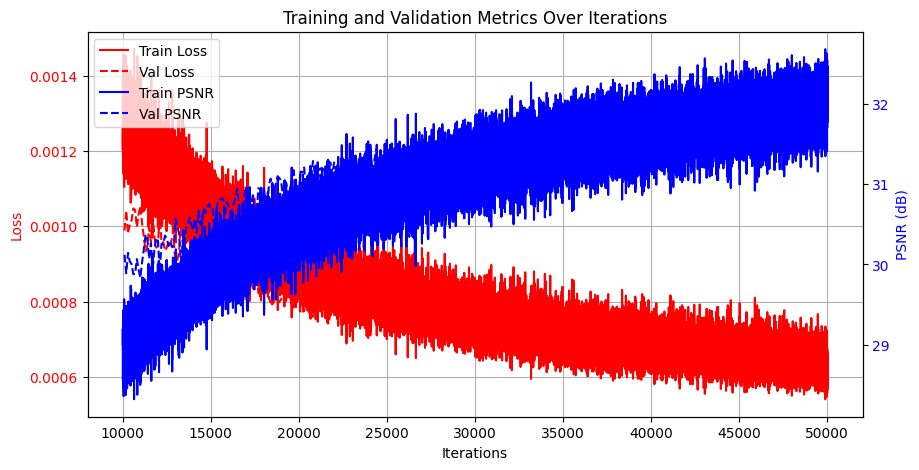

In [21]:
def psnr(mse):
    return -10*math.log10(mse)

def plot_metrics(iteration_steps,
                 train_loss_values, train_psnr_values,
                 val_loss_values, val_psnr_values,
                 filename='metrics_curve.png'):
    plt.figure(figsize=(10,5))  
    ax1 = plt.gca()
    ax1.plot(iteration_steps, train_loss_values, 'r-', label='Train Loss')
    if len(val_loss_values) > 0:
        ax1.plot(val_loss_values[:,0], val_loss_values[:,1], 'r--', label='Val Loss')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss', color='r')
    ax1.tick_params(axis='y', labelcolor='r')
    ax1.grid(True)
    ax2 = ax1.twinx()
    ax2.plot(iteration_steps, train_psnr_values, 'b-', label='Train PSNR')
    if len(val_psnr_values) > 0:
        ax2.plot(val_psnr_values[:,0], val_psnr_values[:,1], 'b--', label='Val PSNR')
    ax2.set_ylabel('PSNR (dB)', color='b')
    ax2.tick_params(axis='y', labelcolor='b')
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    plt.title('Training and Validation Metrics Over Iterations')
    plt.savefig(filename)
    plt.show()


    

data = np.load("lego_200x200.npz")
images_train = data["images_train"] / 255.0
c2ws_train = data["c2ws_train"]
images_val = data["images_val"] / 255.0
c2ws_val = data["c2ws_val"]
c2ws_test = data["c2ws_test"]
focal = data["focal"]
H, W = images_train.shape[1:3]
o_x = W/2
o_y = H/2
K = np.array([[focal,0,o_x],[0,focal,o_y],[0,0,1]],dtype=np.float32)
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset = RaysData(images_train, K, c2ws_train)
os.makedirs("val_images", exist_ok=True)
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

nerf = NeRF(D=8, W=256, Lx=10, Ld=4).to(device)
optimizer = optim.Adam(nerf.parameters(), lr=5e-4)

MSE = nn.MSELoss()

N_iters = 50_000
batch_size = 11_000
n_samples = 100
near = 2.0
far = 6.0
step_size = (far - near)/n_samples

LOAD_ON = True
checkpoint_interval = 1000

def load_checkpoint(checkpoint_dir, nerf, optimizer):
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith(".pt")]
    if len(checkpoints) == 0:
        print("No checkpoints found. Starting from scratch.")
        return 1

    checkpoints.sort(key=lambda x: int(x.split("_")[1].split(".")[0]))
    latest_ckpt = checkpoints[-1]
    ckpt_path = os.path.join(checkpoint_dir, latest_ckpt)
    print(f"Loading checkpoint {ckpt_path}")
    ckpt = torch.load(ckpt_path, map_location=device)
    nerf.load_state_dict(ckpt["nerf_state"])
    optimizer.load_state_dict(ckpt["optimizer_state"])
    start_iter = ckpt["iteration"] + 1
    return start_iter

def save_checkpoint(checkpoint_dir, iteration, nerf, optimizer):
    ckpt_path = os.path.join(checkpoint_dir, f"ckpt_{iteration}.pt")
    torch.save({
        "iteration": iteration,
        "nerf_state": nerf.state_dict(),
        "optimizer_state": optimizer.state_dict()
    }, ckpt_path)
    print(f"Checkpoint saved at iteration {iteration}: {ckpt_path}")

def evaluate_val(nerf, images_val, c2ws_val, K, H, W, o_x, o_y, focal, near, far, n_samples, step_size, device):
    N_val = images_val.shape[0]
    val_losses = []
    val_psnrs = []
    val_renders = []

    for val_img_id in range(N_val):
        val_img = images_val[val_img_id]
        c2w = c2ws_val[val_img_id]
        rays_o_full = []
        rays_d_full = []
        for i in range(H):
            for j in range(W):
                u = j+0.5
                v = i+0.5
                x_c = (u - o_x)*1.0/focal
                y_c = (v - o_y)*1.0/focal
                z_c = 1.0
                x_c = np.array([x_c,y_c,z_c])
                x_c_h = np.concatenate([x_c,[1]],axis=0)
                X_w = (c2w @ x_c_h.T)[:3]
                r_o = c2w[:3,3]
                r_d = X_w - r_o
                r_d = r_d/np.linalg.norm(r_d)
                rays_o_full.append(r_o)
                rays_d_full.append(r_d)

        rays_o_full = torch.from_numpy(np.stack(rays_o_full,0)).float().to(device)
        rays_d_full = torch.from_numpy(np.stack(rays_d_full,0)).float().to(device)

        chunk = 1024
        rendered = []
        nerf.eval()
        with torch.no_grad():
            for start in range(0, rays_o_full.shape[0], chunk):
                end = start+chunk
                ro_batch = rays_o_full[start:end]
                rd_batch = rays_d_full[start:end]
                points, t_vals = sample_along_rays(ro_batch, rd_batch, n_samples, near, far, perturb=False)
                N = ro_batch.shape[0]
                ro_expanded = ro_batch[:,None,:].expand(-1,n_samples,-1).reshape(N*n_samples,3)
                rd_expanded = rd_batch[:,None,:].expand(-1,n_samples,-1).reshape(N*n_samples,3)
                pts_flat = points.reshape(N*n_samples,3)
                d_norm = rd_expanded / torch.norm(rd_expanded, dim=-1,keepdim=True)
                sigma, rgb = nerf(pts_flat, d_norm)
                sigma = sigma.reshape(N,n_samples,1)
                rgb = rgb.reshape(N,n_samples,3)
                colors = volrend(sigma, rgb, step_size)
                rendered.append(colors)
            rendered = torch.cat(rendered,0).cpu().numpy().reshape(H,W,3)
        mse_val = np.mean((rendered - val_img)**2)
        val_psnr = psnr(mse_val)
        val_loss = mse_val
        val_losses.append(val_loss)
        val_psnrs.append(val_psnr)
        val_renders.append(rendered)

    avg_val_loss = np.mean(val_losses)
    avg_val_psnr = np.mean(val_psnrs)
    return avg_val_loss, avg_val_psnr, val_renders

iteration_steps = []
train_psnr_values = []
train_loss_values = []
val_psnr_records = []
val_loss_records = []

start_iter = 1
if LOAD_ON:
    start_iter = load_checkpoint(checkpoint_dir, nerf, optimizer)

for it in tqdm(range(start_iter, N_iters+1), desc="Training"):
    rays_o, rays_d, pix = dataset.sample_rays(batch_size)
    rays_o = torch.from_numpy(rays_o).float().to(device)
    rays_d = torch.from_numpy(rays_d).float().to(device)
    pix = torch.from_numpy(pix).float().to(device)
    points, t_vals = sample_along_rays(rays_o, rays_d, n_samples, near, far, perturb=True)
    B = rays_o.shape[0]
    pts_flat = points.reshape(B*n_samples,3)
    dirs_flat = rays_d[:,None,:].expand(B,n_samples,3).reshape(B*n_samples,3)
    d_norm = dirs_flat / dirs_flat.norm(dim=-1, keepdim=True)
    sigma, rgb = nerf(pts_flat, d_norm)
    sigma = sigma.reshape(B,n_samples,1)
    rgb = rgb.reshape(B,n_samples,3)
    rendered = volrend(sigma, rgb, step_size)
    loss = MSE(rendered, pix)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    current_psnr = psnr(loss.item())
    train_loss_values.append(loss.item())
    train_psnr_values.append(current_psnr)
    iteration_steps.append(it)

    if it % 1000 == 0:
        save_checkpoint(checkpoint_dir, it, nerf, optimizer)

    if it % 100 == 0:
        print(f"Iter {it}/{N_iters}: Loss={loss.item():.4f}, PSNR={current_psnr:.2f}")
        val_loss, val_current_psnr, val_renders = evaluate_val(nerf, images_val, c2ws_val, K, H, W, o_x, o_y, focal, near, far, n_samples, step_size, device)
        print(f"Val Loss: {val_loss:.4f}, Val PSNR: {val_current_psnr:.2f}")

        val_loss_records.append([it, val_loss])
        val_psnr_records.append([it, val_current_psnr])

        val_img_render = val_renders[-1]
        imageio.imwrite(f"val_images/val_step_{it}.png", (val_img_render*255).astype(np.uint8))


val_loss_records = np.array(val_loss_records) if len(val_loss_records) > 0 else np.empty((0,2))
val_psnr_records = np.array(val_psnr_records) if len(val_psnr_records) > 0 else np.empty((0,2))

np.save("iteration_steps.npy", iteration_steps)
np.save("train_loss_values.npy", train_loss_values)
np.save("train_psnr_values.npy", train_psnr_values)
np.save("val_loss_values.npy", val_loss_records)
np.save("val_psnr_values.npy", val_psnr_records)

plot_metrics(iteration_steps,
             train_loss_values, train_psnr_values,
             val_loss_records, val_psnr_records,
             filename='metrics_curve.png')

#### Helper functions to get all the rest of the deliverables.

In [22]:
def visualize_rays_and_samples(dataset, c2ws_train, n_rays=100):
    rays_o, rays_d, _ = dataset.sample_rays(n_rays)
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    cam_positions = c2ws_train[:, :3, 3]
    ax.scatter(cam_positions[:,0], cam_positions[:,1], cam_positions[:,2], c='k', s=5, label='Cameras')
    for i in range(n_rays):
        r_o = rays_o[i]
        r_d = rays_d[i]
        t_values = np.linspace(0, 1, 10)
        line = r_o[None,:] + t_values[:,None]*r_d[None,:]
        ax.plot(line[:,0], line[:,1], line[:,2], c='r', alpha=0.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.title("Cameras and a subset of sampled rays")
    plt.savefig("rays_samples_visualization.png")
    plt.show()

def render_image(nerf, c2w, H, W, K, o_x, o_y, focal, near, far, n_samples, step_size, device):
    rays_o = []
    rays_d = []
    for i in range(H):
        for j in range(W):
            u = j+0.5
            v = i+0.5
            x_c = (u - o_x)*1.0/focal
            y_c = (v - o_y)*1.0/focal
            z_c = 1.0
            x_c = np.array([x_c,y_c,z_c])
            x_c_h = np.concatenate([x_c, np.array([1])],axis=0)
            X_w = (c2w @ x_c_h.T)[:3]
            r_o = c2w[:3,3]
            r_d = X_w - r_o
            r_d = r_d/np.linalg.norm(r_d)
            rays_o.append(r_o)
            rays_d.append(r_d)
    rays_o = torch.from_numpy(np.stack(rays_o,0)).float().to(device)
    rays_d = torch.from_numpy(np.stack(rays_d,0)).float().to(device)
    chunk = 1024
    rendered = []
    nerf.eval()
    with torch.no_grad():
        for start in range(0, rays_o.shape[0], chunk):
            end = start+chunk
            ro_batch = rays_o[start:end]
            rd_batch = rays_d[start:end]
            points, t_vals = sample_along_rays(ro_batch, rd_batch, n_samples, near, far, perturb=False)
            N = ro_batch.shape[0]
            ro_expanded = ro_batch[:,None,:].expand(-1,n_samples,-1).reshape(N*n_samples,3)
            rd_expanded = rd_batch[:,None,:].expand(-1,n_samples,-1).reshape(N*n_samples,3)
            pts_flat = points.reshape(N*n_samples,3)
            d_norm = rd_expanded / torch.norm(rd_expanded, dim=-1, keepdim=True)
            sigma, rgb = nerf(pts_flat, d_norm)
            sigma = sigma.reshape(N,n_samples,1)
            rgb = rgb.reshape(N,n_samples,3)
            colors = volrend(sigma, rgb, step_size)
            rendered.append(colors)
        rendered = torch.cat(rendered,0).cpu().numpy().reshape(H,W,3)
    return rendered

def render_video(nerf, c2ws_test, H, W, K, o_x, o_y, focal, near, far, n_samples, step_size, device):
    frames = []
    for i in tqdm(range(c2ws_test.shape[0]), desc="Rendering Video"):
        c2w = c2ws_test[i]
        img = render_image(nerf, c2w, H, W, K, o_x, o_y, focal, near, far, n_samples, step_size, device)
        imageio.imwrite(f"frame_{i}.png", (img*255).astype(np.uint8))
        frames.append((img*255).astype(np.uint8))
    imageio.mimsave('novel_view.mp4', frames, fps=30)

Report the visualization of the rays and samples you draw at a single training step (along with the cameras), similar to the plot we show above. Plot up to 100 rays to make it less crowded.

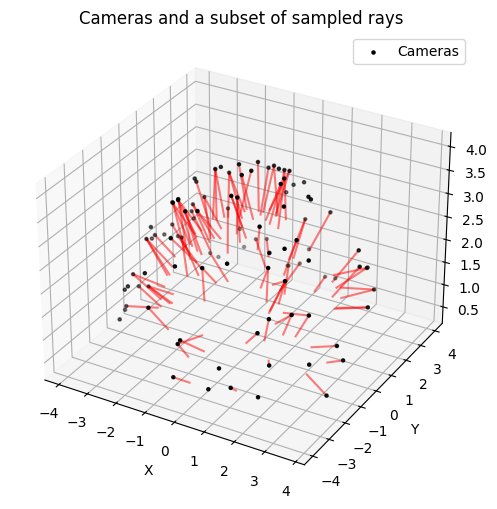

In [23]:
visualize_rays_and_samples(dataset, c2ws_train, n_rays=100)

After you train the network, you can use it to render a novel view image of the lego from arbitrary camera extrinsic. Show a spherical rendering of the lego video using the provided cameras extrinsics (c2ws_test in the npz file). You should be get a video like this (left is 10 after minutes training, right is 2.5 hrs training)

In [24]:
render_video(nerf, c2ws_test, H, W, K, o_x, o_y, focal, near, far, n_samples, step_size, device)

Rendering Video:   0%|          | 0/60 [00:00<?, ?it/s]

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 200) to (208, 208) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x41f6f580] Warning: data is not aligned! This can lead to a speed loss
